In [ ]:
# | hide
# from chewc.core import *
# from chewc.pop import *
# from chewc.sp import *
# from chewc.trait import *

# chewc

> JAX breeding sim

## Developer Guide

If you are new to using `nbdev` here are some useful pointers to get you started.

### Install chewc in Development mode

```sh
# make sure chewc package is installed in development mode
$ pip install -e .

# make changes under nbs/ directory
# ...

# compile to have changes apply to chewc
$ nbdev_prepare
```

## Usage

### Installation

Install latest from the GitHub [repository][repo]:

```sh
$ pip install git+https://github.com/cjGO/chewc.git
```


[repo]: https://github.com/cjGO/chewc
[docs]: https://cjGO.github.io/chewc/
[pypi]: https://pypi.org/project/chewc/
[conda]: https://anaconda.org/cjGO/chewc

### Documentation

Documentation can be found hosted on this GitHub [repository][repo]'s [pages][docs].

[repo]: https://github.com/cjGO/chewc
[docs]: https://cjGO.github.io/chewc/

## How to use

=== Multi-Trait Selection Experiment: Yield vs Disease Resistance ===
Simulating a breeding program with correlated traits representing real-world trade-offs

=== Adding Correlated Traits ===
Founder population with 2 traits: Population(nInd=300, nTraits=2, has_ebv=No)
Initial yield mean: 99.58
Initial resistance mean: 50.37
Initial correlation: -0.028

=== Running Selection Strategies ===

Running Yield Only: Select only for high yield
  Final yield: 138.79 (+39.21)
  Final resistance: 45.07 (+-5.30)

Running Resistance Only: Select only for disease resistance
  Final yield: 86.03 (+-13.56)
  Final resistance: 83.06 (+32.68)

Running Balanced Index: Economic index favoring yield
  Final yield: 132.56 (+32.97)
  Final resistance: 54.25 (+3.87)

Running Equal Index: Equal economic weights
  Final yield: 127.10 (+27.51)
  Final resistance: 63.45 (+13.08)

Running Resistance Focus: Economic index favoring resistance
  Final yield: 110.19 (+10.61)
  Final resistance: 76.79 (+26.42)

Runnin

ValueError: x and y must have same first dimension, but have shapes (16,) and (26,)

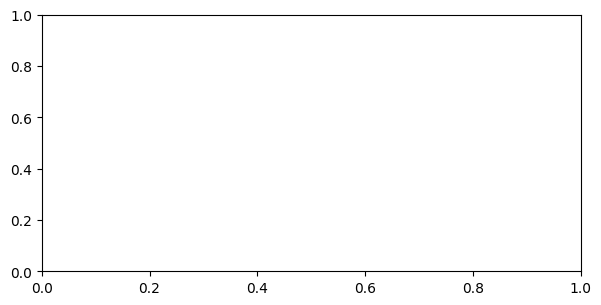

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from chewc.population import quick_haplo, Population
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross

def calculate_selection_index(phenotypes, weights):
    """
    Calculate selection index values for multi-trait selection.
    
    Args:
        phenotypes: Array of shape (n_ind, n_traits)
        weights: Array of economic weights for each trait
    
    Returns:
        Selection index values for each individual
    """
    return jnp.sum(phenotypes * weights, axis=1)

def run_multitrait_selection(key, founder_pop, sp_with_traits, strategy, n_generations=25):
    """
    Runs multi-trait selection with different strategies.
    
    Args:
        key: JAX random key
        founder_pop: Initial population with phenotypes
        sp_with_traits: Simulation parameters with traits defined
        strategy: Selection strategy dict with weights and method
        n_generations: Number of generations to simulate
    
    Returns:
        Dict with generation statistics for both traits
    """
    current_pop = founder_pop
    
    # Storage for results
    results = {
        'yield_means': [],
        'resistance_means': [],
        'yield_stds': [],
        'resistance_stds': [],
        'correlation': []
    }
    
    # Store founder generation
    yield_pheno = current_pop.pheno[:, 0]
    resistance_pheno = current_pop.pheno[:, 1]
    
    results['yield_means'].append(float(jnp.mean(yield_pheno)))
    results['resistance_means'].append(float(jnp.mean(resistance_pheno)))
    results['yield_stds'].append(float(jnp.std(yield_pheno)))
    results['resistance_stds'].append(float(jnp.std(resistance_pheno)))
    results['correlation'].append(float(jnp.corrcoef(yield_pheno, resistance_pheno)[0, 1]))
    
    selection_percent = 0.20  # Select top 10%
    n_parents = int(current_pop.nInd * selection_percent)
    n_crosses_per_gen = current_pop.nInd
    next_id = 10000
    
    for generation in range(1, n_generations + 1):
        # Apply selection strategy
        if strategy['method'] == 'yield_only':
            # Select only on yield (trait 0)
            selection_values = current_pop.pheno[:, 0]
        elif strategy['method'] == 'resistance_only':
            # Select only on disease resistance (trait 1)
            selection_values = current_pop.pheno[:, 1]
        elif strategy['method'] == 'index':
            # Use economic selection index
            selection_values = calculate_selection_index(current_pop.pheno, strategy['weights'])
        elif strategy['method'] == 'independent':
            # Independent culling: require minimum thresholds for both traits
            yield_threshold = jnp.percentile(current_pop.pheno[:, 0], 70)  # Top 30% for yield
            resistance_threshold = jnp.percentile(current_pop.pheno[:, 1], 70)  # Top 30% for resistance
            
            # Find individuals meeting both criteria
            meets_yield = current_pop.pheno[:, 0] >= yield_threshold
            meets_resistance = current_pop.pheno[:, 1] >= resistance_threshold
            meets_both = meets_yield & meets_resistance
            
            # If not enough individuals meet both criteria, relax thresholds
            eligible_indices = jnp.where(meets_both)[0]
            if len(eligible_indices) < n_parents:
                # Fall back to selection index if independent culling is too restrictive
                selection_values = calculate_selection_index(current_pop.pheno, jnp.array([0.5, 0.5]))
            else:
                # Select randomly from those meeting criteria, then by index within that group
                selection_values = jnp.where(meets_both, 
                                           calculate_selection_index(current_pop.pheno, jnp.array([0.5, 0.5])),
                                           -jnp.inf)
        
        # Select top individuals
        sorted_indices = jnp.argsort(selection_values)
        top_indices = sorted_indices[-n_parents:]
        
        # Create cross plan
        key, cross_key = jax.random.split(key)
        mother_indices = jax.random.choice(cross_key, top_indices, (n_crosses_per_gen,), replace=True)
        key, father_key = jax.random.split(key)
        father_indices = jax.random.choice(father_key, top_indices, (n_crosses_per_gen,), replace=True)
        
        cross_plan = jnp.stack([mother_indices, father_indices], axis=1)
        
        # Execute crosses
        key, mating_key = jax.random.split(key)
        next_gen_pop = make_cross(
            key=mating_key,
            pop=current_pop,
            cross_plan=cross_plan,
            sp=sp_with_traits,
            next_id_start=next_id
        )
        
        # Set phenotypes
        key, pheno_key = jax.random.split(key)
        next_gen_pop = set_pheno(
            key=pheno_key,
            pop=next_gen_pop,
            traits=sp_with_traits.traits,
            ploidy=sp_with_traits.ploidy,
            h2=jnp.array([0.4, 0.6])  # Different heritabilities for the two traits
        )
        
        # Store statistics
        yield_pheno = next_gen_pop.pheno[:, 0]
        resistance_pheno = next_gen_pop.pheno[:, 1]
        
        results['yield_means'].append(float(jnp.mean(yield_pheno)))
        results['resistance_means'].append(float(jnp.mean(resistance_pheno)))
        results['yield_stds'].append(float(jnp.std(yield_pheno)))
        results['resistance_stds'].append(float(jnp.std(resistance_pheno)))
        results['correlation'].append(float(jnp.corrcoef(yield_pheno, resistance_pheno)[0, 1]))
        
        current_pop = next_gen_pop
        next_id += n_crosses_per_gen
    
    return results

# Main experiment setup
print("=== Multi-Trait Selection Experiment: Yield vs Disease Resistance ===")
print("Simulating a breeding program with correlated traits representing real-world trade-offs")

key = jax.random.PRNGKey(123)

# Create founder population
key, founder_key = jax.random.split(key)
founder_pop, genetic_map = quick_haplo(
    key=founder_key,
    n_ind=300,  # Larger population for multi-trait selection
    n_chr=7,    # More chromosomes for realistic genome
    n_loci_per_chr=800,
    ploidy=2,
    inbred=False
)

# Initialize simulation parameters
sp = SimParam.from_founder_pop(
    founder_pop=founder_pop,
    gen_map=genetic_map,
    sexes="yes",
    track_pedigree=True
)

# Add two correlated traits: Yield and Disease Resistance
print("\n=== Adding Correlated Traits ===")
key, trait_key = jax.random.split(key)

# Create negative correlation between yield and disease resistance (-0.3)
# This represents the biological trade-off often seen in plant breeding
correlation_matrix = jnp.array([
    [1.0, -0.3],   # Yield has negative correlation with resistance
    [-0.3, 1.0]    # Disease resistance has negative correlation with yield
])

sp_with_traits = add_trait_a(
    key=trait_key,
    founder_pop=founder_pop,
    sim_param=sp,
    n_qtl_per_chr=40,
    mean=jnp.array([100.0, 50.0]),      # Yield mean=100, Resistance mean=50
    var=jnp.array([20.0, 15.0]),        # Different genetic variances
    cor_a=correlation_matrix,            # Negative genetic correlation
    gamma=False
)

# Set phenotypes with different heritabilities
key, pheno_key = jax.random.split(key)
founder_pop_with_pheno = set_pheno(
    key=pheno_key,
    pop=founder_pop,
    traits=sp_with_traits.traits,
    ploidy=sp_with_traits.ploidy,
    h2=jnp.array([0.4, 0.6])  # Yield h²=0.4, Disease resistance h²=0.6
)

print(f"Founder population with 2 traits: {founder_pop_with_pheno}")
print(f"Initial yield mean: {float(jnp.mean(founder_pop_with_pheno.pheno[:, 0])):.2f}")
print(f"Initial resistance mean: {float(jnp.mean(founder_pop_with_pheno.pheno[:, 1])):.2f}")
print(f"Initial correlation: {float(jnp.corrcoef(founder_pop_with_pheno.pheno[:, 0], founder_pop_with_pheno.pheno[:, 1])[0, 1]):.3f}")

# Define selection strategies
strategies = {
    'Yield Only': {
        'method': 'yield_only',
        'description': 'Select only for high yield'
    },
    'Resistance Only': {
        'method': 'resistance_only', 
        'description': 'Select only for disease resistance'
    },
    'Balanced Index': {
        'method': 'index',
        'weights': jnp.array([0.6, 0.4]),  # 60% weight on yield, 40% on resistance
        'description': 'Economic index favoring yield'
    },
    'Equal Index': {
        'method': 'index',
        'weights': jnp.array([0.5, 0.5]),  # Equal weights
        'description': 'Equal economic weights'
    },
    'Resistance Focus': {
        'method': 'index',
        'weights': jnp.array([0.3, 0.7]),  # 30% weight on yield, 70% on resistance
        'description': 'Economic index favoring resistance'
    },
    'Independent Culling': {
        'method': 'independent',
        'description': 'Must meet minimum thresholds for both traits'
    }
}

# Run experiments
all_results = {}
print(f"\n=== Running Selection Strategies ===")

for strategy_name, strategy_config in strategies.items():
    print(f"\nRunning {strategy_name}: {strategy_config['description']}")
    
    key, strategy_key = jax.random.split(key)
    results = run_multitrait_selection(
        key=strategy_key,
        founder_pop=founder_pop_with_pheno,
        sp_with_traits=sp_with_traits,
        strategy=strategy_config,
        n_generations=15
    )
    
    all_results[strategy_name] = results
    
    final_yield = results['yield_means'][15]
    final_resistance = results['resistance_means'][15]
    yield_gain = final_yield - results['yield_means'][0]
    resistance_gain = final_resistance - results['resistance_means'][0]
    
    print(f"  Final yield: {final_yield:.2f} (+{yield_gain:.2f})")
    print(f"  Final resistance: {final_resistance:.2f} (+{resistance_gain:.2f})")

# Create comprehensive visualization
print("\n=== Creating Multi-Strategy Comparison ===")

fig = plt.figure(figsize=(16, 12))
generations = range(16)  # 0 to 15

# Create a 3x2 subplot layout
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Colors for different strategies
colors = plt.cm.Set1(np.linspace(0, 1, len(strategies)))
strategy_names = list(strategies.keys())

# Plot 1: Yield progress over time
ax1 = fig.add_subplot(gs[0, 0])
for i, (strategy_name, results) in enumerate(all_results.items()):
    ax1.plot(generations, results['yield_means'], 'o-', 
             color=colors[i], linewidth=2, markersize=4, label=strategy_name)

ax1.set_xlabel('Generation')
ax1.set_ylabel('Mean Yield')
ax1.set_title('Yield Progress by Selection Strategy')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Disease resistance progress over time  
ax2 = fig.add_subplot(gs[0, 1])
for i, (strategy_name, results) in enumerate(all_results.items()):
    ax2.plot(generations, results['resistance_means'], 's-', 
             color=colors[i], linewidth=2, markersize=4, label=strategy_name)

ax2.set_xlabel('Generation')
ax2.set_ylabel('Mean Disease Resistance')
ax2.set_title('Disease Resistance Progress by Selection Strategy')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Trade-off trajectory (yield vs resistance over generations)
ax3 = fig.add_subplot(gs[1, :])
for i, (strategy_name, results) in enumerate(all_results.items()):
    # Plot trajectory with arrows showing direction over time
    ax3.plot(results['yield_means'], results['resistance_means'], 'o-', 
             color=colors[i], linewidth=2, markersize=4, alpha=0.7, label=strategy_name)
    
    # Add arrow to show direction of progress
    if len(results['yield_means']) > 5:
        ax3.annotate('', xy=(results['yield_means'][15], results['resistance_means'][15]),
                    xytext=(results['yield_means'][10], results['resistance_means'][10]),
                    arrowprops=dict(arrowstyle='->', color=colors[i], lw=2))
    
    # Mark starting and ending points
    ax3.scatter(results['yield_means'][0], results['resistance_means'][0], 
               s=100, color=colors[i], marker='o', alpha=0.8, edgecolor='black')
    ax3.scatter(results['yield_means'][15], results['resistance_means'][15], 
               s=120, color=colors[i], marker='*', alpha=0.9, edgecolor='black')

ax3.set_xlabel('Mean Yield')
ax3.set_ylabel('Mean Disease Resistance')
ax3.set_title('Trait Trade-off Trajectories (○ = start, ★ = end, → = direction)')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax3.grid(True, alpha=0.3)

# Plot 4: Final gains comparison
ax4 = fig.add_subplot(gs[2, 0])
yield_gains = [results['yield_means'][15] - results['yield_means'][0] 
               for results in all_results.values()]
resistance_gains = [results['resistance_means'][15] - results['resistance_means'][0] 
                   for results in all_results.values()]

x_pos = np.arange(len(strategy_names))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, yield_gains, width, 
                color='gold', label='Yield Gain', alpha=0.8)
bars2 = ax4.bar(x_pos + width/2, resistance_gains, width, 
                color='forestgreen', label='Resistance Gain', alpha=0.8)

ax4.set_xlabel('Selection Strategy')
ax4.set_ylabel('Total Genetic Gain (15 generations)')
ax4.set_title('Final Genetic Gains by Strategy')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(strategy_names, rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{height:.1f}', ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{height:.1f}', ha='center', va='bottom', fontsize=8)

# Plot 5: Genetic diversity over time (using standard deviation as proxy)
ax5 = fig.add_subplot(gs[2, 1])
for i, (strategy_name, results) in enumerate(all_results.items()):
    # Plot total genetic diversity (sum of std for both traits)
    total_diversity = np.array(results['yield_stds']) + np.array(results['resistance_stds'])
    ax5.plot(generations, total_diversity, 'o-', 
             color=colors[i], linewidth=2, markersize=3, label=strategy_name)

ax5.set_xlabel('Generation')
ax5.set_ylabel('Total Phenotypic Diversity (sum of std)')
ax5.set_title('Genetic Diversity Preservation')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n" + "="*80)
print("MULTI-TRAIT BREEDING EXPERIMENT RESULTS")
print("="*80)

print(f"\nTrait Characteristics:")
print(f"• Yield: h² = 0.4, Initial mean = {all_results['Yield Only']['yield_means'][0]:.1f}")
print(f"• Disease Resistance: h² = 0.6, Initial mean = {all_results['Yield Only']['resistance_means'][0]:.1f}")
print(f"• Genetic Correlation: -0.3 (negative trade-off)")

print(f"\nFinal Results After 15 Generations:")
print("Strategy" + " " * 12 + "| Yield Gain | Resistance Gain | Total Index* | Diversity Loss")
print("-" * 85)

baseline_diversity = (all_results['Yield Only']['yield_stds'][0] + 
                     all_results['Yield Only']['resistance_stds'][0])

for strategy_name, results in all_results.items():
    yield_gain = results['yield_means'][15] - results['yield_means'][0]
    resistance_gain = results['resistance_means'][15] - results['resistance_means'][0]
    total_index = 0.6 * yield_gain + 0.4 * resistance_gain  # Economic index
    
    final_diversity = results['yield_stds'][15] + results['resistance_stds'][15]
    diversity_loss = baseline_diversity - final_diversity
    
    print(f"{strategy_name:<20} | {yield_gain:>10.2f} | {resistance_gain:>15.2f} | "
          f"{total_index:>11.2f} | {diversity_loss:>12.2f}")

print("\n*Total Index = 0.6×Yield_gain + 0.4×Resistance_gain (economic weights)")

# Breeding recommendations
print(f"\n" + "="*60)
print("BREEDING RECOMMENDATIONS")
print("="*60)

# Find best strategies for different objectives
best_yield = max(all_results.items(), key=lambda x: x[1]['yield_means'][15] - x[1]['yield_means'][0])
best_resistance = max(all_results.items(), key=lambda x: x[1]['resistance_means'][15] - x[1]['resistance_means'][0])
best_balanced = max(all_results.items(), key=lambda x: 0.6*(x[1]['yield_means'][15] - x[1]['yield_means'][0]) + 
                                                       0.4*(x[1]['resistance_means'][15] - x[1]['resistance_means'][0]))

print(f"🌾 For Maximum Yield: {best_yield[0]}")
print(f"   Achieved {best_yield[1]['yield_means'][15] - best_yield[1]['yield_means'][0]:.2f} yield gain")

print(f"🛡️  For Maximum Disease Resistance: {best_resistance[0]}")
print(f"   Achieved {best_resistance[1]['resistance_means'][15] - best_resistance[1]['resistance_means'][0]:.2f} resistance gain")

print(f"⚖️  For Balanced Improvement: {best_balanced[0]}")
print(f"   Best economic return with balanced trait improvement")

print(f"\n💡 Key Insights:")
print(f"• Negative correlation creates trade-offs requiring strategic decisions")
print(f"• Single-trait selection maximizes gains in target trait but may sacrifice the other")
print(f"• Selection indices allow optimization of multiple traits simultaneously")
print(f"• Independent culling ensures minimum standards but may limit genetic gains")
print(f"• Genetic diversity preservation varies significantly by strategy")

print(f"\nExperiment completed! This demonstrates real-world breeding decisions.")